# Test energy and lifetime fits

### Author: JJGC

In [22]:
import time
print("Last updated on ", time.asctime())

Last updated on  Sat Aug  4 11:33:27 2018


In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

### General imports

In [24]:
import os
import datetime 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

### Imports from IC

In [25]:
from   invisible_cities.evm  .ic_containers  import Measurement

### Local imports

In [120]:
from krcal.core.fit_energy_functions import gaussian_parameters
from krcal.core.histo_functions      import h1
from krcal.core.histo_functions      import h1d
from krcal.core.histo_functions      import plot_histo
from krcal.core.fit_histograms       import gaussian_histo_example
from krcal.core.fit_energy_functions import fit_energy
from krcal.core.fit_energy_functions import plot_fit_energy
from krcal.core.fit_energy_functions import plot_fit_energy_chi2
from krcal.core.fit_energy_functions import print_fit_energy
from krcal.core.fit_energy_functions import fit_gaussian_experiments
from krcal.core.fit_energy_functions import fit_gaussian_experiments_variable_mean_and_std
from krcal.core.fit_energy_functions import gaussian_params_from_fcs
from krcal.core.stat_functions       import gaussian_experiment
from krcal.core.stat_functions       import gaussian_experiments
from krcal.core.stat_functions       import gaussian_experiments_variable_mean_and_std
from krcal.core.stat_functions       import energy_lt
from krcal.core.stat_functions       import smear_e
from krcal.core.stat_functions       import energy_lt_experiment
from krcal.core.stat_functions       import energy_lt_experiments
from krcal.core.fit_histograms       import histo_gaussian_experiment_sample
from krcal.core.fit_histograms       import histo_gaussian_params_and_pulls
from krcal.core.fit_histograms       import histo_lt_params_and_pulls
from krcal.core.fit_lt_functions     import fit_lifetime
from krcal.core.fit_lt_functions     import fit_lifetime_experiments
from krcal.core.fit_lt_functions     import lt_params_from_fcs
from krcal.core.fit_lt_functions     import plot_fit_lifetime
from krcal.core.fit_lt_functions     import print_fit_lifetime
from krcal.core.fit_lt_functions     import plot_fit_lifetime_chi2

In [27]:
from krcal.core.kr_types import PlotLabels
from krcal.core.kr_types import FitType
from krcal.core          import fit_functions_ic as fitf

## Gaussian fits

### First example:
- Generate guassian data
- histogram
- fit a gaussian
- plot fit
- print fit

#### Generate gaussian data

In [15]:
Nevt  = 1e6
mean = 100
sigma = 10
e = gaussian_experiment(nevt=Nevt, mean=mean, std=sigma)

#### Compute a gaussian seed. 

- Notice that mean and sigma of gaussian seed are close to true values, with small errors

In [16]:
seed = gaussian_parameters(e, (0,200), 1)
print(seed)

GaussPar(mu=Measurement(value=100.00217680667802, uncertainty=0.009994627651664985), std=Measurement(value=9.994627651664985, uncertainty=0.0070672725215640345), amp=Measurement(value=39915.67212961392, uncertainty=0.017715025127075134))


#### Histogramming the gaussian distribution

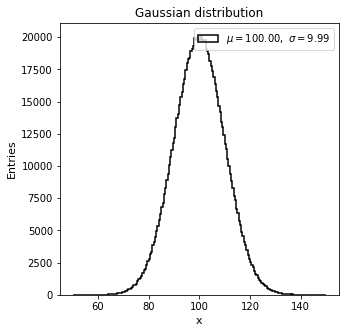

In [17]:
r = mean - 5 * sigma, mean + 5 * sigma
h1d(e, bins=200, range = r, pltLabels=PlotLabels(x='x', y='Entries', title='Gaussian distribution'),  figsize=(5,5))

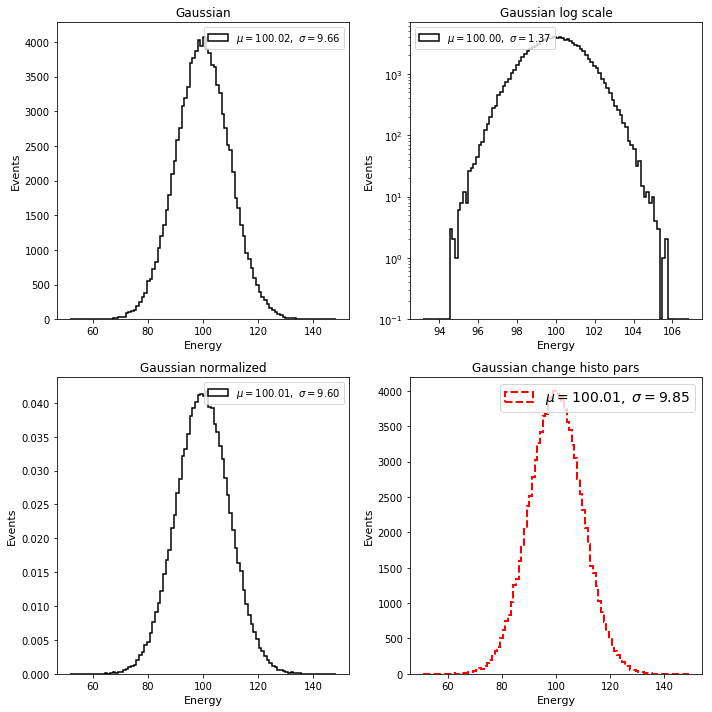

In [19]:
gaussian_histo_example(mean = 100, nevt=1e+5)

#### Fitting a gaussian to the distribution

In [20]:
fc = fit_energy(e, nbins=100, range=(0,200), n_sigma =3)

  Fit was valid = True
 Emu       = 100.00033265569957 +-0.010163206191463485 
 E sigma   = 10.013240953525749 +-0.007619733331463092 
 chi2    = 0.77114849295939 
 sigma E/E (FWHM)     (%) =23.531037963446558
 sigma E/E (FWHM) Qbb (%) =3.039079587785838 


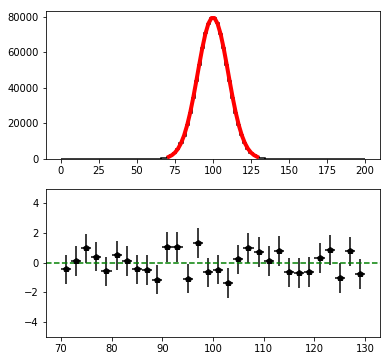

In [28]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(2, 1, 1)
plot_fit_energy(fc)
ax = fig.add_subplot(2, 1, 2)
plot_fit_energy_chi2(fc)
print_fit_energy(fc)

### run many gaussian experiments and show the pull

In [45]:
mean = 1e+4
std  = 0.02
sigma = mean * std
exps = gaussian_experiments(mexperiments = 1000, nsample =1000, mean=mean, std = sigma)

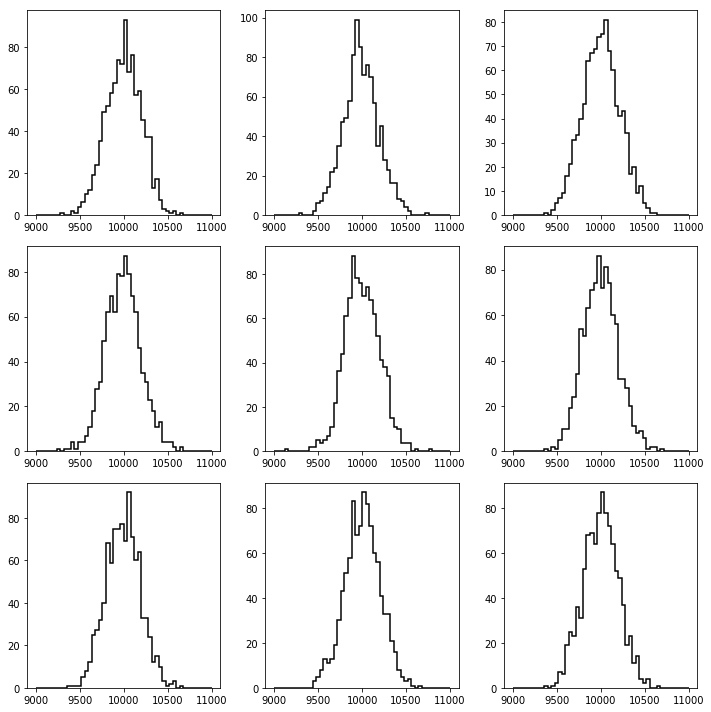

In [46]:
histo_gaussian_experiment_sample(exps, mexperiments = 1000, bins = 50, range_e = (9e+3,11e+3), samples=9, canvas=(3,3), figsize=(10,10))

In [33]:
fcs = fit_gaussian_experiments(exps, nbins = 50, range =(9e+3, 11e+3), n_sigma =3)

In [35]:
mus, umus, stds, ustds, chi2s = gaussian_params_from_fcs(fcs)

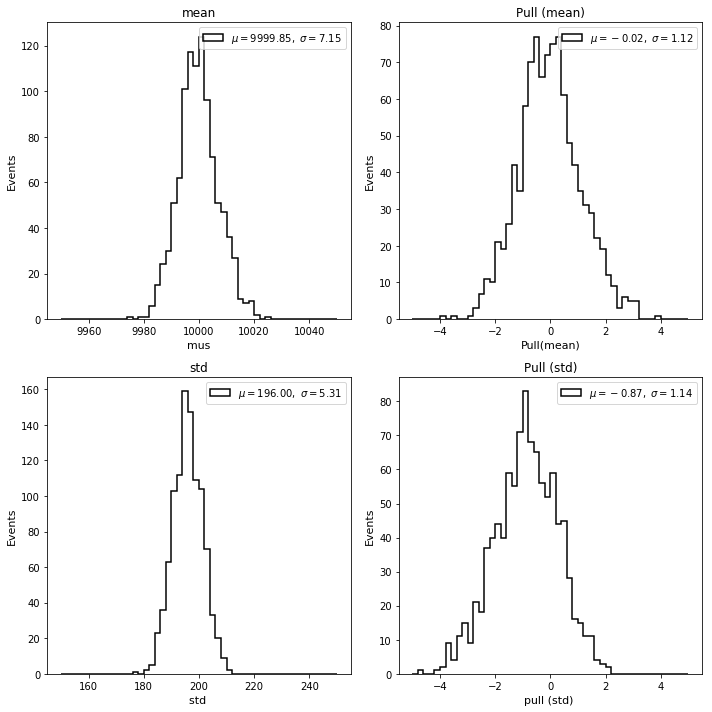

In [36]:
histo_gaussian_params_and_pulls(mean, sigma, mus, umus, stds, ustds, figsize=(10,10))

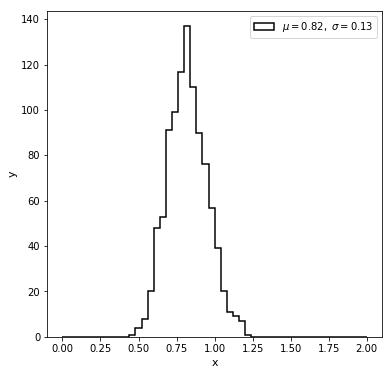

In [39]:
h1d(chi2s, bins = 50, range =(0,2))

### Show that the difference between the gaussian parameters estimated with a fit and the statistical estimator (mean, std) is gaussian

In [100]:
means, stds, exps = gaussian_experiments_variable_mean_and_std(mexperiments = 1000,
                                                  nsample      = 100,
                                                  mean_range   = (100, 1000),
                                                  std_range    = (1, 50))

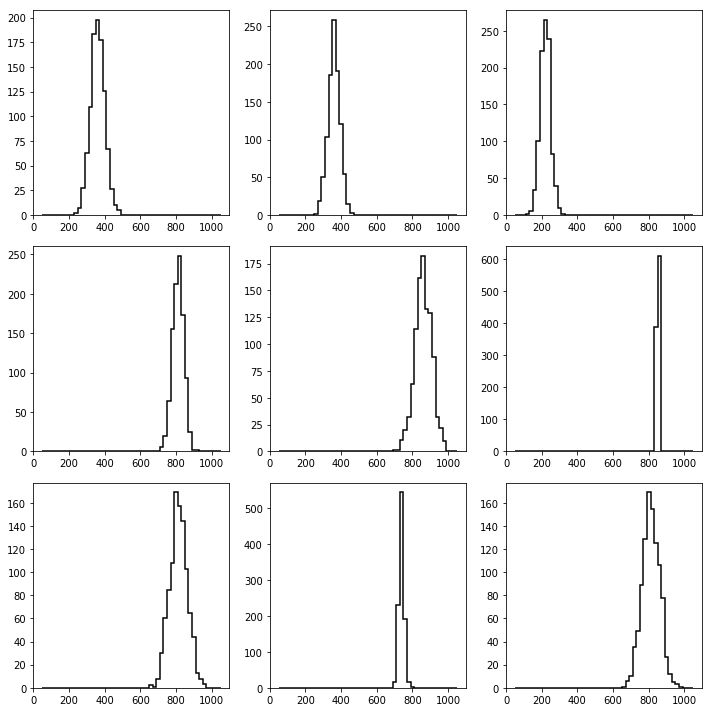

In [101]:
histo_gaussian_experiment_sample(exps, mexperiments = 1000, bins = 50, range_e = (50,1050), samples=9, canvas=(3,3), figsize=(10,10))

In [121]:
SEED, MU, STD, AVG, RMS, CHI2 = fit_gaussian_experiments_variable_mean_and_std(means, stds, exps, bins = 50, n_sigma=3)

 fit failed for seed  = GaussPar(mu=Measurement(value=246.4530566807197, uncertainty=1.3217121819081108), std=Measurement(value=41.75439193211524, uncertainty=0.9350602310640195), amp=Measurement(value=50.2542802624144, uncertainty=2.3438484136680677)), due to RunTimeWarning, retry fit 
 fit failed for seed  = GaussPar(mu=Measurement(value=779.9560258456002, uncertainty=1.5437016251270441), std=Measurement(value=48.74285243292208, uncertainty=1.092109722616617), amp=Measurement(value=48.97574640492224, uncertainty=2.737513109710231)), due to RunTimeWarning, retry fit 
 fit failed for seed  = GaussPar(mu=Measurement(value=795.801849962906, uncertainty=1.5277393463877353), std=Measurement(value=48.2146405198589, uncertainty=1.0808175670741524), amp=Measurement(value=48.07455143048661, uncertainty=2.709207873345958)), due to RunTimeWarning, retry fit 
 fit failed for seed  = GaussPar(mu=Measurement(value=484.6546841209898, uncertainty=1.0092817850532807), std=Measurement(value=31.88436015

In [122]:
mean  = np.array([x.value for x in SEED])
sigma = np.array([x.uncertainty for x in SEED])

In [123]:
avg = np.array([x.value for x in AVG])
avg_u = np.array([x.uncertainty for x in AVG])
rms = np.array([x.value for x in RMS])
rms_u = np.array([x.uncertainty for x in RMS])

In [124]:
mu = np.array([x.value for x in MU])
mu_u = np.array([x.uncertainty for x in MU])
std = np.array([x.value for x in STD])
std_u = np.array([x.uncertainty for x in STD])

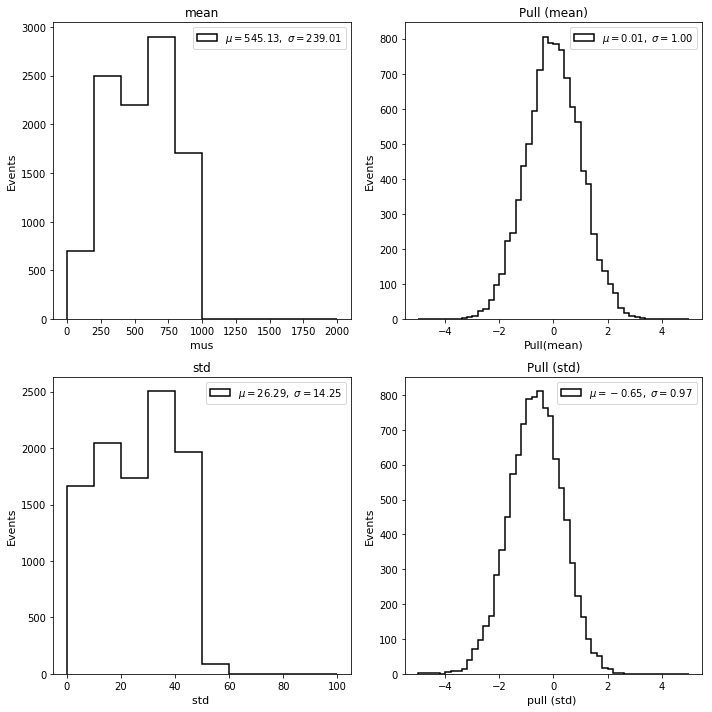

In [130]:
histo_gaussian_params_and_pulls(mean, sigma, avg, avg_u, rms, rms_u,
                                bin_mus    = 10,
                                bin_stds   = 10,
                                bin_pull   = 50,
                                range_mus  = (0, 2000),
                                range_stds = (0, 100),
                                range_pull = (-5,5),
                                figsize=(10,10))

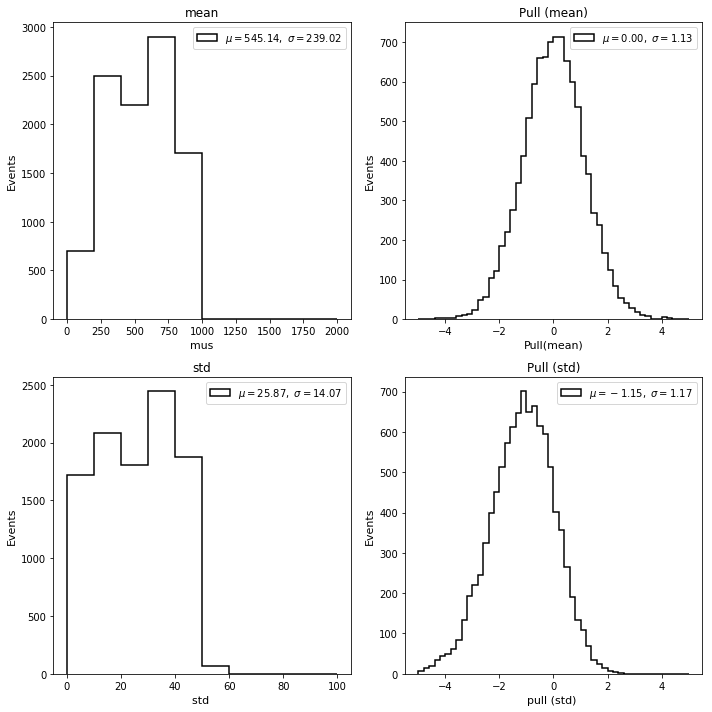

In [131]:
histo_gaussian_params_and_pulls(mean, sigma, mu, mu_u, std, std_u,
                                bin_mus    = 10,
                                bin_stds   = 10,
                                bin_pull   = 50,
                                range_mus  = (0, 2000),
                                range_stds = (0, 100),
                                range_pull = (-5,5),
                                figsize=(10,10))

#### The avg and rms of the gaussian distributions are slighly better behaved that those of the fits

- Pull is better for the avg and the rms than for the mu and std
- mu is unbiased in both cases but rms less umbiased than std

## Exponential fits

In [160]:
Nevt  = int(1e5)
e0 = 1e+4 # pes
std = 0.02 * e0
lt = 2000 # lifetime in mus
nbins_z = 12

### generate data

In [161]:
z, es = energy_lt_experiment(Nevt, e0, lt, std)                         

In [162]:
xs, ys, yus     = fitf.profileX(z, es, nbins_z)

### Histograms

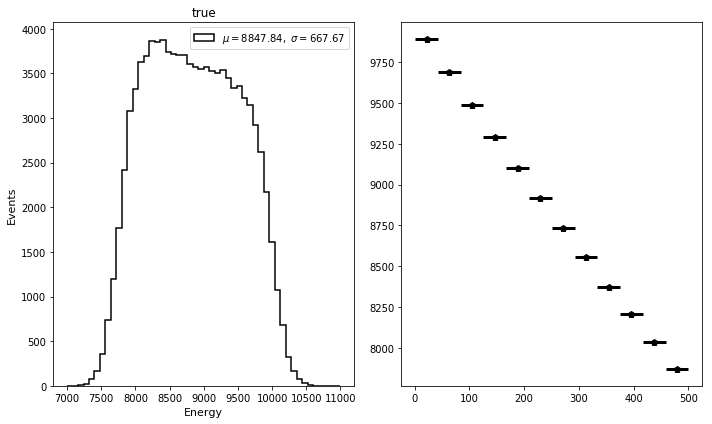

In [163]:
fig = plt.figure(figsize=(10,6 ))
pltLabels =PlotLabels(x='Energy', y='Events', title='true')
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(es, bins=50, range=(7e+3,11e+3))
plot_histo(pltLabels, ax)

ax      = fig.add_subplot(1, 2, 2)
plt.errorbar(xs, ys, yus, np.diff(xs)[0]/2, fmt="kp", ms=7, lw=3)

plt.tight_layout()

### Fit lifetime  data to binned and unbinned mode

In [164]:

ti = time.time()
fc = fit_lifetime(z, es, fit = FitType.profile, nbins_z=nbins_z, nbins_e=50, range_z=(0, 500), range_e=(7000, 11000))
tf = time.time()
print(f't = {tf -ti}')

t = 0.017258167266845703


In [165]:
ti = time.time()
fcu = fit_lifetime(z, es, fit = FitType.unbined, uerrors = False, nbins_z=nbins_z, nbins_e=50, range_z=(0, 500), range_e=(7000, 11000))
tf = time.time()
print(f't = {tf -ti}')

t = 0.017221927642822266


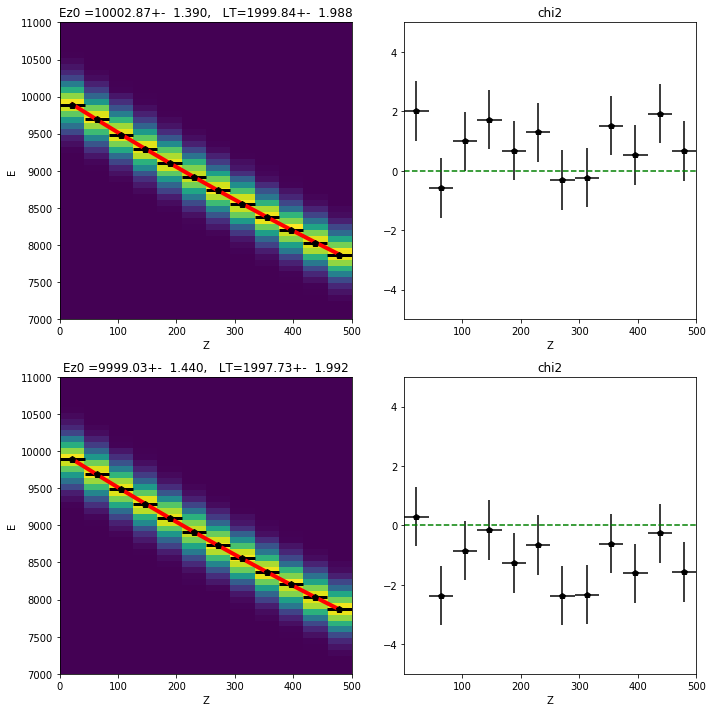

In [166]:
fig = plt.figure(figsize=(10,10))
ax      = fig.add_subplot(2, 2, 1)
plot_fit_lifetime(fc)

ax      = fig.add_subplot(2, 2, 2)
plot_fit_lifetime_chi2(fc)

ax      = fig.add_subplot(2, 2, 3)
plot_fit_lifetime(fcu)

ax      = fig.add_subplot(2, 2, 4)
plot_fit_lifetime_chi2(fcu)

plt.tight_layout()


In [167]:
print_fit_lifetime(fc)

 Ez0     = 10002.869437153993 +-1.389630102930995 
 LT      = 1999.8402456049125 +-1.9877413330064153 
 chi2    = 1.5828228577305348 


In [168]:
print_fit_lifetime(fcu)

 Ez0     = 9999.026110150602 +-1.4400231052899113 
 LT      = 1997.7276651501202 +-1.9916525884246523 
 chi2    = 2.2729765274109393 


### Run experiments

In [169]:
mexperiments = 1e+3
nsample      = 1e+3
zs, es = energy_lt_experiments(mexperiments, nsample, e0, lt, std)

In [172]:
fcp = fit_lifetime_experiments(zs, es, fit=FitType.profile, nbins_z=12)

In [178]:
fcu  = fit_lifetime_experiments(zs, es, fit=FitType.unbined, uerrors = False, nbins_z=12)
fcu2 = fit_lifetime_experiments(zs, es, fit=FitType.unbined, uerrors = True, nbins_z=12)

In [174]:
e0s, ue0s, lts,ults, chi2p = lt_params_from_fcs(fcp)

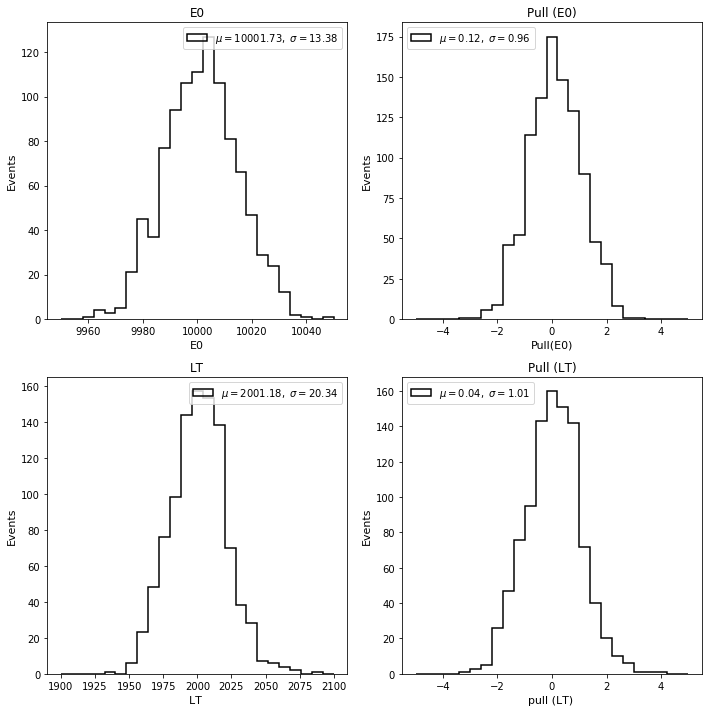

In [175]:
histo_lt_params_and_pulls(e0, lt, e0s,ue0s,lts,ults, 
                          bin_e0s    = 25,
                          bin_lts    = 25,
                          bin_pull   = 25,
                          range_e0s  = (9950,10050),
                          range_lts  = (1900,2100),
                          range_pull = (-5,5),figsize=(10,10))

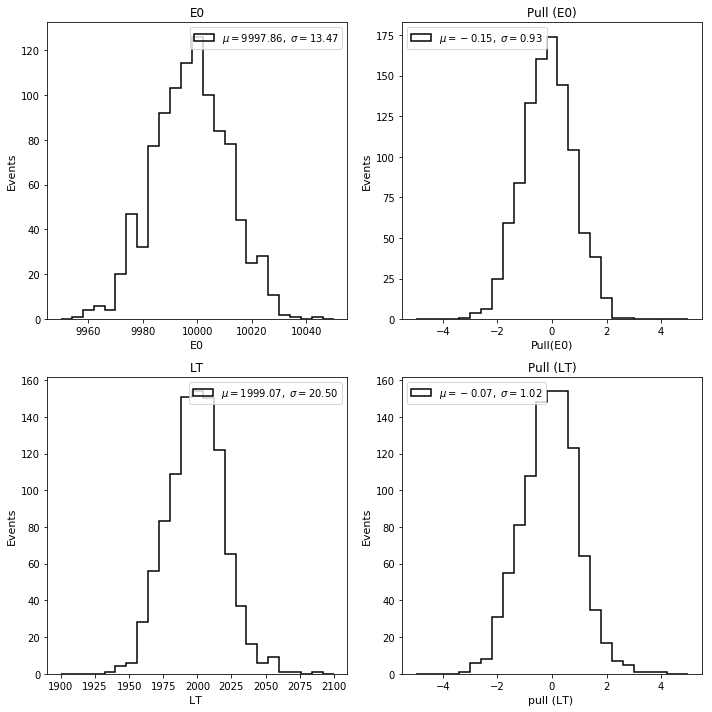

In [176]:
e0s, ue0s, lts,ults, chi2u = lt_params_from_fcs(fcu)
histo_lt_params_and_pulls(e0, lt, e0s,ue0s,lts,ults, 
                          bin_e0s    = 25,
                          bin_lts    = 25,
                          bin_pull   = 25,
                          range_e0s  = (9950,10050),
                          range_lts  = (1900,2100),
                          range_pull = (-5,5),figsize=(10,10))

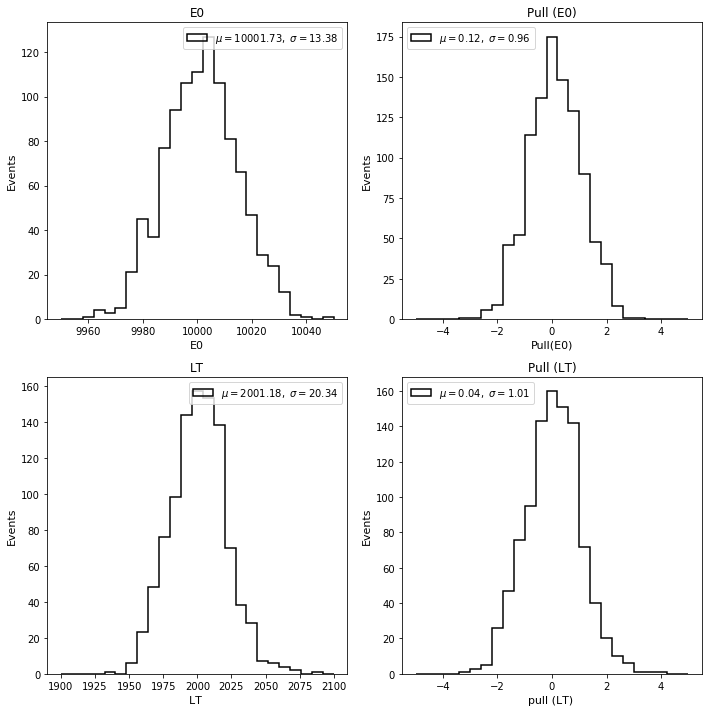

In [179]:
e0s, ue0s, lts,ults, chi2u2 = lt_params_from_fcs(fcu2)
histo_lt_params_and_pulls(e0, lt, e0s,ue0s,lts,ults, 
                          bin_e0s    = 25,
                          bin_lts    = 25,
                          bin_pull   = 25,
                          range_e0s  = (9950,10050),
                          range_lts  = (1900,2100),
                          range_pull = (-5,5),figsize=(10,10))

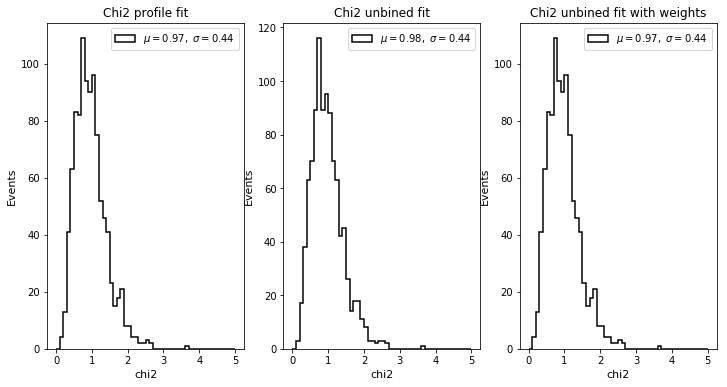

In [182]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 3, 1)
pltLabels =PlotLabels(x='chi2', y='Events', title='Chi2 profile fit')
(_) = h1(chi2p, bins=50, range=(0,5))
plot_histo(pltLabels, ax)

ax = fig.add_subplot(1, 3, 2)
pltLabels =PlotLabels(x='chi2', y='Events', title='Chi2 unbined fit')
(_) = h1(chi2u, bins=50, range=(0,5))
plot_histo(pltLabels, ax)

ax = fig.add_subplot(1, 3, 3)
pltLabels =PlotLabels(x='chi2', y='Events', title='Chi2 unbined fit with weights')
(_) = h1(chi2u2, bins=50, range=(0,5))
plot_histo(pltLabels, ax)




